In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from keras.datasets import imdb

In [5]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

decoded_X_train = [decode_review(review) for review in X_train]
decoded_X_test = [decode_review(review) for review in X_test]


In [12]:
import nltk
try:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('punkt_tab')
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")


import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(text, method='lemmatize'):
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]

    if method == 'stem':
        tokens = [stemmer.stem(t) for t in tokens]
    elif method == 'lemmatize':
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)

processed_lemmatized = [preprocess(review, method='lemmatize') for review in decoded_X_train]
processed_stemmed = [preprocess(review, method='stem') for review in decoded_X_train]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [13]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(processed_lemmatized)
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

positive_reviews = df_tfidf[np.array(y_train) == 1]
negative_reviews = df_tfidf[np.array(y_train) == 0]

top_pos = positive_reviews.mean().sort_values(ascending=False).head(10)
top_neg = negative_reviews.mean().sort_values(ascending=False).head(10)

print("Top 10 Positive TF-IDF Words:\n", top_pos)
print("\nTop 10 Negative TF-IDF Words:\n", top_neg)

Top 10 Positive TF-IDF Words:
 br       0.103169
movie    0.056665
film     0.056503
one      0.032620
great    0.025676
good     0.024769
like     0.024575
story    0.024432
time     0.023887
well     0.021695
dtype: float64

Top 10 Negative TF-IDF Words:
 br       0.116357
movie    0.071740
film     0.052684
one      0.032862
bad      0.031131
like     0.030826
even     0.024883
good     0.024010
time     0.023089
would    0.022906
dtype: float64


In [20]:
from google.colab import files
uploaded = files.upload()


Saving glove.6B.zip to glove.6B.zip


In [21]:
import zipfile

with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('glove')

In [22]:
embedding_index = {}
with open('glove/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

def get_embedding_vector(text):
    tokens = text.split()
    vectors = [embedding_index.get(t) for t in tokens if t in embedding_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

X_glove = np.array([get_embedding_vector(review) for review in processed_lemmatized])

In [24]:
def compare_words(word1, word2):
    vec1 = embedding_index.get(word1)
    vec2 = embedding_index.get(word2)
    if vec1 is not None and vec2 is not None:
        similarity = cosine_similarity([vec1], [vec2])[0][0]
        print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
    else:
        print(f"One or both words not found in embedding.")

compare_words("good", "excellent")
compare_words("bad", "terrible")

Cosine similarity between 'good' and 'excellent': 0.7936
Cosine similarity between 'bad' and 'terrible': 0.7072


TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      2437
           1       0.87      0.90      0.88      2563

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



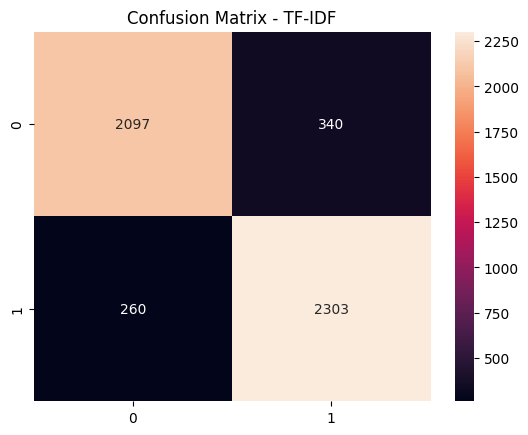

In [26]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_train, test_size=0.2, random_state=42)

model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("TF-IDF Classification Report:\n", classification_report(y_test_tfidf, y_pred_tfidf))
sns.heatmap(confusion_matrix(y_test_tfidf, y_pred_tfidf), annot=True, fmt="d")
plt.title("Confusion Matrix - TF-IDF")
plt.show()

GloVe Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      2437
           1       0.80      0.81      0.80      2563

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



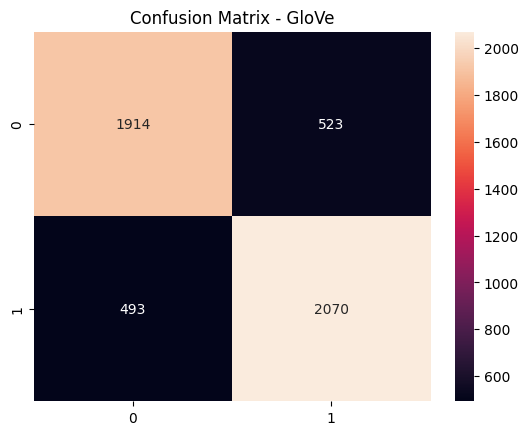

In [27]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y_train, test_size=0.2, random_state=42)

model_glove = LogisticRegression(max_iter=1000)
model_glove.fit(X_train_glove, y_train_glove)

y_pred_glove = model_glove.predict(X_test_glove)

print("GloVe Classification Report:\n", classification_report(y_test_glove, y_pred_glove))
sns.heatmap(confusion_matrix(y_test_glove, y_pred_glove), annot=True, fmt="d")
plt.title("Confusion Matrix - GloVe")
plt.show()

*   TF-IDF vs. GloVe
  
  GloVe captures word meaning and context, resulting in better generalization, especially for similar words not explicitly seen in training.

*   Stemming vs. Lemmatization
  
  Lemmatization retains meaningful word forms, aiding interpretability and preserving semantic meaning, whereas stemming can be too aggressive.


  
  Challenges:


*   Some words not present in GloVe
*   Short reviews or slang/typos can degrade embedding quality.
*   Tokenization needs customization for informal text.





